## Point Cloud/DEM Alignment (or Co-registration)
#### Adapted from the [ASP Documentation](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html#pc-align)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
import asp_binder_utils as asp_utils
from fetch_dem import opentopo_utils
import xyzservices
import rioxarray
import rasterio

## Universal settings

In [4]:
#verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
verbose = True # will print all the logs printed by ASP
alignment_algortihm = 'point-to-plane' # suggested to use point-to-point if the terrain variability is low (more flat terrain cases)
max_displacement = -1 #you might have to play with this to adapt to different datasets
tsrs = 'EPSG:32610' # inpute projection
tr = 30 #DEM resolution

## Preprocessing 0: Data Download
* For the purpose of this tutorial, we will register the ASTER DEM produced using the stereo processing tutorial to the Copernicus GLO-30 DEM.
    * To run this tutorial without running the stereo processing tutorial, we have archived the ASTER DEM produced using the ASTER camera models and orthorectified imagery (Type 3) on [Zenodo](https://zenodo.org/records/10208419). We will fetch it directly from zenodo.

* Alternatively, users can bring their own DEMs, and explore the tutorial using the same! Please follow the below guidelines to do so.
    * To perform this in a github codespace session, go to the file explorer on the right, do a right click and select upload, then upload the DEMs of your choice from the file browser.
    * See also this [stack exhange answer](https://stackoverflow.com/questions/62284623/how-can-i-upload-a-file-to-a-github-codespaces-environment)

* When you change the DEMs to a different site than the site used by default, make sure to change the projected corrdinate system definition (t_srs) 

### 0.1 Download ASTER ASP DEM over Mt. Rainier

In [5]:
aster_dem_fn = 'aster_orthorectified-DEM.tif'
#ASTER Sample has been staged on Zenodo:
#https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1
zenodo_url = 'https://zenodo.org/records/10208419/files/aster_orthorectified-DEM.tif?download=1'
if os.path.exists(aster_dem_fn):
    print(f"file {aster_dem_fn} already downloaded")
else:
    response = requests.get(zenodo_url)
    #Check for 200
    if response.ok:
        print ('OK!')
    else:
        print ('Query failed')
        sys.exit()
    #Write to disk
    open(aster_dem_fn, 'wb').write(response.content)
    print(f"file {aster_dem_fn} saved")

OK!
file aster_orthorectified-DEM.tif saved


### 0.2 Download Copernicus DEM over a similar extent

In [6]:

# get aoi extent in geographic coordinates
aoi_extent = asp_utils.subsetBBox(aster_dem_fn,'EPSG:4326')
#in_crs = rasterio.open(dem_file).crs

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/workspaces/asp_tutorials/tutorials/asp_binder_utils.py:114: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
 

In [7]:
opentopo_api_key = 'demoapikeyot2022' #paste your open topography api key within the quotes
reference_cop30 = opentopo_utils.get_dem('COP30_E',aoi_extent,apikey=opentopo_api_key,proj=tsrs)
reference_cop30

Ellipsoidal versions of COP30 is not provided automatically...
Will perform vertical datum adjustment downstream.....
https://portal.opentopography.org/API/globaldem?demtype=COP30&west=-122.3432849411124&south=46.72248482449153&east=-121.35468538023632&north=47.32888038665895&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326+EPSG:3855' -t_srs 'EPSG:32610+EPSG:4979' COP30_E_temp.tif COP30_E.tif
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326+EPSG:3855' -t_srs 'EPSG:32610+EPSG:4979' COP30_E_temp.tif COP30_E.tif
Creating output file that is 3149P x 2833L.
Processing COP30_E_temp.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
/srv/conda/envs/notebook/bin/gdal_edit.py COP30_E.tif -a_srs EPSG:32610+EPSG:4979


Child returned 0
Child returned 0


'COP30_E.tif'

## 1. Perform Co-registration (using ASP's [pc_align](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html) algorithm)

In [8]:
pc_align = find_executable('pc_align')
refdem = reference_cop30
src_dem = aster_dem_fn
alignment_dir  = 'alignment/aster_aligned2COP30'
alignment_call = f'{pc_align} --highest-accuracy  --save-transformed-source-points --alignment-method {alignment_algortihm}  --max-displacement {max_displacement} {refdem} {src_dem} -o {alignment_dir}'
asp_utils.run_bash_command(alignment_call,verbose=verbose)

/srv/StereoPipeline/bin/pc_align --highest-accuracy  --save-transformed-source-points --alignment-method point-to-plane  --max-displacement -1 COP30_E.tif aster_orthorectified-DEM.tif -o alignment/aster_aligned2COP30
	--> Setting number of processing threads to: 4

Creating output directory: "alignment".
Writing log info to: alignment/aster_aligned2COP30-log-pc_align-02-27-2325-1537.txt
Detected datum from COP30_E.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (1.79769e+308, 1.79769e+308) width: 0 height: 0)
Source box:    (Origin: (1.

writing to alignment/aster_aligned2COP30-iterationInfo.csv


Match ratio: 0.75001
Alignment took 2.97351 [s]
Number of errors: 73111
Output: error percentile of smallest errors (meters): 16%: 1.93187, 50%: 6.7898, 84%: 15.6941
Output: mean of smallest errors (meters): 25%: 1.51295, 50%: 3.193, 75%: 5.2275, 100%: 9.70207
Final error computation took 0.140347 [s]
Alignment transform (origin is planet center):
    0.9999999953288642  8.729020432836782e-05 -4.150533191345044e-05      518.4286080501042
 -8.72847562676228e-05     0.9999999875780076  0.0001312454042845992     -844.3683618921787
 4.151678783605546e-05 -0.0001312417808887727     0.9999999905259759     -405.2520579015836
                     0                      0                      0                      1
Centroid of source points (Cartesian, meters): Vector3(-2299602.4,-3699555.9,4644442.1)
Centroid of source points (lat,lon,z): Vector3(47.027411,-121.86462,819.42341)

Translation vector (Cartesian, meters): Vector3(2.7352503,-34.040493,-15.231861)
Translation vector (North-East-Do

Child returned 0


### Some useful information from the alignment log 
* Note the "Input mean of smallest errors"
    * This line tells us 25,50,75 and 100th percentile values of filtered elevation difference before alignment
* Note the "Output mean of smallest errors"
    * This line tells us 25,50,75 and 100th percentile values of filtered elevation difference after alignment
* Note the "Translation vector (North-East-Down, meters)
    * This line tells us the shift vectors applied to the source DEM in North-South, East-West, and vertical directions, repsectively. 
* Note the message: "Maximum displacement of points between the source cloud with any initial transform applied to it and the source cloud after alignment to the reference:"
    * This lines tells us the total cummulative 3D shift applied to the source DEM

## 2. Grid the aligned source point cloud into a DEM (using ASP's [point2dem](https://stereopipeline.readthedocs.io/en/latest/tools/point2dem.html) algorithm)
* Tada: we have the aligned results with us!  
* The output is in ASP 4-band point cloud tiff file. We will need to re-grid it to generate the aligned source DEM.
* Recall the point2dem gridding call in the stereo processing tutorial

In [9]:

point2dem = find_executable('point2dem')
tsrs = tsrs
#p2dem_args = '--errorimage'
nodata_value = -9999.0
pointcloud = glob.glob(alignment_dir+'*-trans_source.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' --nodata-value {nodata_value} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(aligned_dem))


Gridding pointcloud alignment/aster_aligned2COP30-trans_source.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --nodata-value -9999.0 alignment/aster_aligned2COP30-trans_source.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment/aster_aligned2COP30-trans_source-log-point2dem-02-27-2326-1941.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2461,2283) px.
Writing: alignment/aster_aligned2COP30-trans_source-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 73.7692%
DEM saved at alignment/aster_aligned2COP30-t

Child returned 0


## 3. Compare DEMs before and after alignment (using ASP's [geodiff](https://stereopipeline.readthedocs.io/en/latest/tools/geodiff.html) algorithm)

### 3.1 Computing difference of DEMs before co-registration

In [10]:

geodiff = find_executable('geodiff')
initial_output_prefix = 'initial'
print(f"Computing elevation difference before alignment between {refdem} and {src_dem}\n\n")
geodiff_call = f"{geodiff} {refdem} {src_dem} -o {initial_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
initial_elevation_difference_fn = glob.glob(initial_output_prefix+'-diff.tif')[0]
print("\n\nInitial elevation difference saved at {}".format(initial_elevation_difference_fn))

Computing elevation difference before alignment between COP30_E.tif and aster_orthorectified-DEM.tif


/srv/StereoPipeline/bin/geodiff COP30_E.tif aster_orthorectified-DEM.tif -o initial
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM 2: -3.40282e+38
Writing difference file: initial-diff.tif
        --> Differencing: [******************************************] Complete!


Initial elevation difference saved at initial-diff.tif


Child returned 0


### 3.2 Computing difference of DEMs after co-registration

In [11]:

geodiff = find_executable('geodiff')
aligned_output_prefix = 'coregistered'
print(f"Computing elevation difference after alignment between {refdem} and {aligned_dem}\n\n")
geodiff_call = f"{geodiff} {refdem} {aligned_dem} -o {aligned_output_prefix}"
asp_utils.run_bash_command(geodiff_call,verbose=verbose)
aligned_elevation_difference_fn = glob.glob(aligned_output_prefix+'-diff.tif')[0]
print("\n\nFinal elevation difference, after alignment saved at {}".format(aligned_elevation_difference_fn))


Computing elevation difference after alignment between COP30_E.tif and alignment/aster_aligned2COP30-trans_source-DEM.tif


/srv/StereoPipeline/bin/geodiff COP30_E.tif alignment/aster_aligned2COP30-trans_source-DEM.tif -o coregistered
	--> Setting number of processing threads to: 4
	Found input nodata value for DEM 2: -9999
Writing difference file: coregistered-diff.tif
        --> Differencing: [******************************************] Complete!


Final elevation difference, after alignment saved at coregistered-diff.tif


Child returned 0


## 4. Analyse Results

/srv/conda/envs/notebook/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


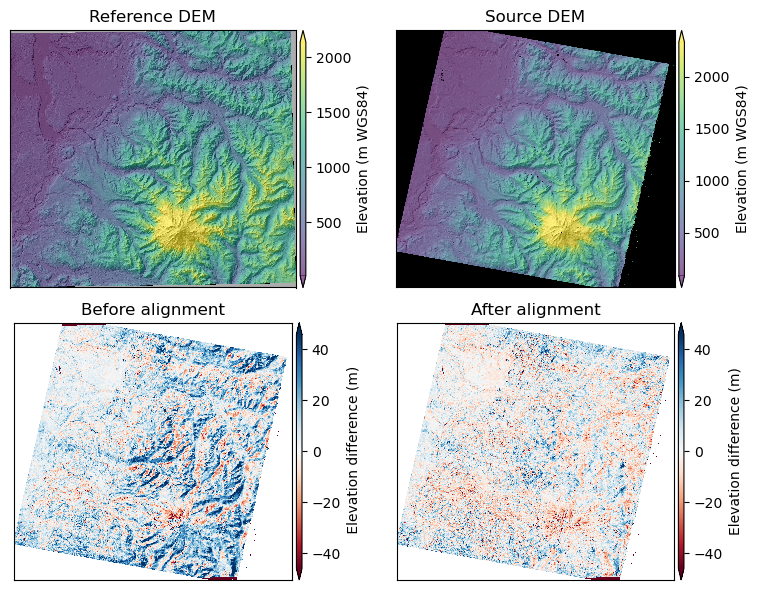

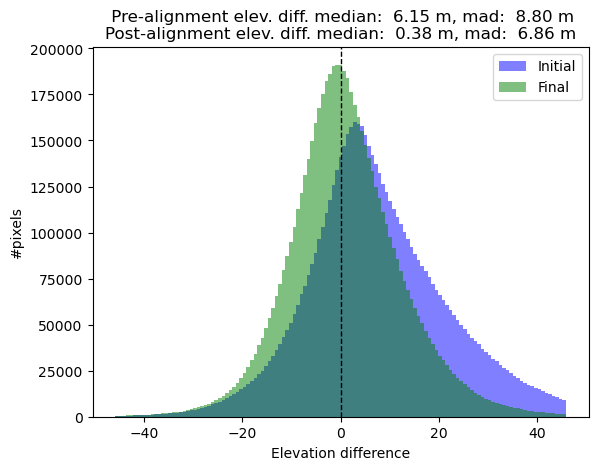

In [12]:
asp_utils.plot_alignment_maps(refdem,src_dem,initial_elevation_difference_fn,aligned_elevation_difference_fn)

### Final Thoughts
* From the plots above, we see that after alignment/co-registration, the bias in the spatial elevation difference map is removed.
* The histogram of elevation difference before and after alignment shows the distribution centers around zero (indicated by the median), with a reduced spread (indicated by the mad, which stands for [median absolute difference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html)) 
* Now try the tools out for dataset of your choice!

## Additional things to keep in mind: 
* Higher resolution DEM/point cloud should be treated as reference in the pc_align call.
* Max displacement should be chosen carefully